    1) 실시간 위치 인증이 맞는가?
    Users frequently 'check-in' with the app to update their current location, which is then broadcast to their friends.
    -> 실시간 위치인증 맞음. brightkite 또한 실시간 위치인증이 맞다고 함.

    2) 중분류 마치기 -> 아직 진행중. 뉴욕과 도쿄 유저에 대한 데이터셋이 별도로 있는데, 이 경우 카테고리가 보다 적어 

In [1]:
import numpy as np
import pandas as pd
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime, timedelta
import math

In [2]:
# UTC_time 변경 함수

def date_convert(date_to_convert):
    pru = datetime.datetime.strptime(date_to_convert, '%a %b %d %H:%M:%S +0000 %Y')+ datetime.timedelta(hours=-240//60)
    return pru.strftime('%b %d %Y %H:%M:%S')

def tzo_convert(tzo_to_convert):
    return  timedelta(hours=tzo_to_convert/60)

In [3]:
nyc_filepath = 'C:/Users/piai/Desktop/code_file/dataset_WWW2019/dataset_TSMC2014_NYC.csv\dataset_TSMC2014_NYC.csv'
custom_date_parser = lambda x: datetime.strptime(x, "%a %b %d %H:%M:%S +0000 %Y")

nyc_data = pd.read_csv(nyc_filepath,parse_dates=['utcTimestamp'],date_parser=custom_date_parser)

nyc_data["utcTimestampOffset"] = nyc_data.utcTimestamp + nyc_data.timezoneOffset.apply(tzo_convert)

nyc_data["hour"] = nyc_data.utcTimestampOffset.dt.hour

# 야행성인지 체크하는 컬럼 생성. 저녁 6시부터 새벽 6시까지 활동한 POI는 야행성 Ture로 표시.
nyc_data["nightlife"] = nyc_data['hour'].apply(lambda x: 'True' if (18 <= x < 24) or (0 <= x < 6)else 'False')

# 요일이 무엇인지 0~6 순서로 설정. 월요일이 0, 일요일이 6.
nyc_data["dayofweek"] = nyc_data.utcTimestampOffset.dt.dayofweek

# 평일과 주말을 구분. 평일이면 True, 주말이면 False.
nyc_data["weekday"] = nyc_data['dayofweek'].apply(lambda x: 'True' if x <= 4 else 'False')

In [4]:
# 카테고리는 251개가 존재한다.
nyc_data['venueCategory'].drop_duplicates().count()

251

In [5]:
nyc_data['venueCategory'].drop_duplicates()

0         Arts & Crafts Store
1                      Bridge
2              Home (private)
3              Medical Center
4                  Food Truck
                 ...         
102807        Photography Lab
110352          Garden Center
139848           Music School
158923                 Castle
167530            Pet Service
Name: venueCategory, Length: 251, dtype: object

<AxesSubplot:xlabel='dayofweek'>

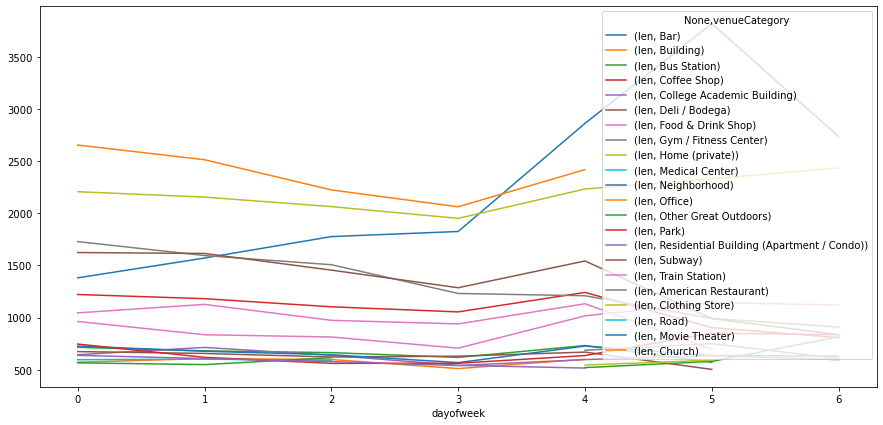

In [6]:
fig, ax = plt.subplots(figsize=(15,7))
pru= nyc_data.groupby([ 'dayofweek','venueCategory']).venueId.agg([len])
pru2 =pru.query('len > 500')
pru2.unstack().plot(ax=ax)

In [7]:
pru.sort_values(['len'], ascending= False).head(60)

,,len
dayofweek,venueCategory,
5,Bar,3822
4,Bar,2864
6,Bar,2737
0,Office,2656
1,Office,2515
6,Home (private),2436
4,Office,2420
5,Home (private),2331
4,Home (private),2234


<AxesSubplot:>

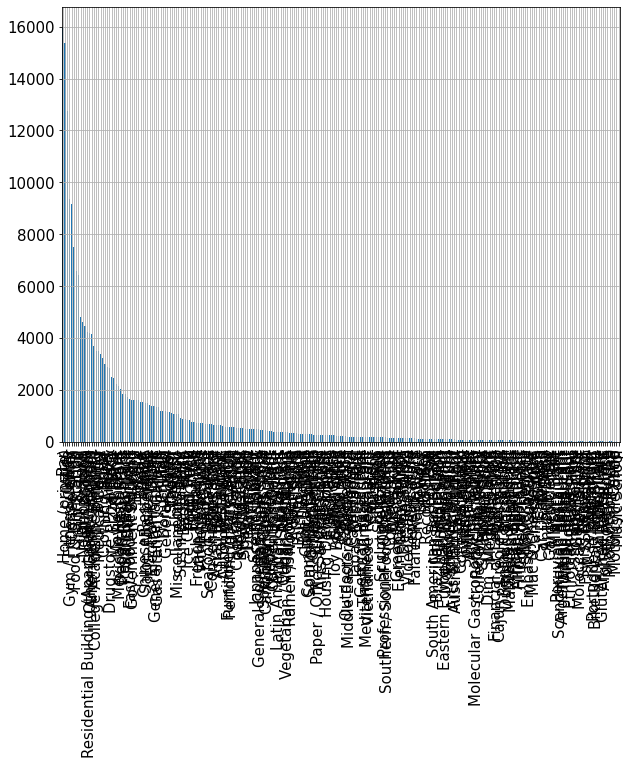

In [8]:
CountStatus = pd.value_counts(nyc_data['venueCategory'], sort=True)
CountStatus.plot.bar()
CountStatus.plot.bar(grid=True, figsize=(10,8), fontsize=15)  # figsize, fontsize 조정

In [9]:
nyc_data.head()

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday
0,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,40.719810,-74.002581,-240,2012-04-03 18:00:09,2012-04-03 14:00:09,14,False,1,True
1,979,4a43c0aef964a520c6a61fe3,4bf58dd8d48988d1df941735,Bridge,40.606800,-74.044170,-240,2012-04-03 18:00:25,2012-04-03 14:00:25,14,False,1,True
2,69,4c5cc7b485a1e21e00d35711,4bf58dd8d48988d103941735,Home (private),40.716162,-73.883070,-240,2012-04-03 18:02:24,2012-04-03 14:02:24,14,False,1,True
3,395,4bc7086715a7ef3bef9878da,4bf58dd8d48988d104941735,Medical Center,40.745164,-73.982519,-240,2012-04-03 18:02:41,2012-04-03 14:02:41,14,False,1,True
4,87,4cf2c5321d18a143951b5cec,4bf58dd8d48988d1cb941735,Food Truck,40.740104,-73.989658,-240,2012-04-03 18:03:00,2012-04-03 14:03:00,14,False,1,True


In [10]:
len(nyc_data['userId'].unique())

1083

In [11]:
len(nyc_data['venueCategory'].unique())

251

In [24]:
# 유저 아이디 별로 정렬 후
# 유저 아이디 행 수만큼만 len 돌려서 time delta 하고,
# 이대로 컬럼 하나 추가하기.
nyc_data_sorted = nyc_data.sort_values(by=['userId', 'utcTimestampOffset'], ascending=[True, True])

In [25]:
nyc_data_sorted.head()

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday
2454,1,4abc1f51f964a520798620e3,4bf58dd8d48988d1ce941735,Seafood Restaurant,40.781558,-73.975792,-240,2012-04-04 23:31:31,2012-04-04 19:31:31,19,True,2,True
3660,1,4d4ac10da0ef54814b6ffff6,4bf58dd8d48988d157941735,American Restaurant,40.784018,-73.974524,-240,2012-04-07 17:42:24,2012-04-07 13:42:24,13,False,5,False
5603,1,4db44994cda1c57c82583709,4bf58dd8d48988d1f1931735,General Entertainment,40.739398,-73.993210,-240,2012-04-08 18:20:29,2012-04-08 14:20:29,14,False,6,False
5783,1,4a541923f964a52008b31fe3,4bf58dd8d48988d14e941735,American Restaurant,40.785677,-73.976498,-240,2012-04-08 20:02:10,2012-04-08 16:02:10,16,False,6,False
6696,1,40f1d480f964a5205b0a1fe3,4bf58dd8d48988d143941735,Breakfast Spot,40.719929,-74.008532,-240,2012-04-09 16:20:52,2012-04-09 12:20:52,12,False,0,True


In [26]:
nyc_data_sorted.reset_index(inplace= True, drop= True)
#nyc_data_sorted.drop(['index'], axis=1, inplace= True)

In [27]:
# for i in range(len(nyc_data_sorted) -1):
#    if i == len(nyc_data_sorted) - 1:
#        continue
#    if nyc_data_sorted.loc[i, "userId"] != nyc_data_sorted.loc[i+1, "userId"]:
#        nyc_data_sorted.loc[i, 'time_diff'] = pd.to_timedelta(0, unit='h')
#        nyc_data_sorted.loc[i+1, 'time_diff'] = pd.to_timedelta(0, unit='h')
#    if (i > 0) & (nyc_data_sorted.loc[i, "userId"] != nyc_data_sorted.loc[i-1, "userId"]):
#        nyc_data_sorted.loc[i, "userId"] = nyc_data_sorted.loc[i, 'time_diff'] = pd.to_timedelta(0, unit='h')
# nyc_data_sorted.loc[len(nyc_data_sorted)-1,'time_diff'] = pd.to_timedelta(0, unit='h')

In [28]:
nyc_data_sorted['time_diff'] = (nyc_data_sorted.utcTimestampOffset.shift(-1) - nyc_data_sorted.utcTimestampOffset)

In [49]:
nyc_data_sorted

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,duplicate,timedelta_min
0,1,4abc1f51f964a520798620e3,4bf58dd8d48988d1ce941735,Seafood Restaurant,40.781558,-73.975792,-240,2012-04-04 23:31:31,2012-04-04 19:31:31,19,True,2,True,2 days 18:10:53,False,3970.883333
1,1,4d4ac10da0ef54814b6ffff6,4bf58dd8d48988d157941735,American Restaurant,40.784018,-73.974524,-240,2012-04-07 17:42:24,2012-04-07 13:42:24,13,False,5,False,1 days 00:38:05,False,1478.083333
2,1,4db44994cda1c57c82583709,4bf58dd8d48988d1f1931735,General Entertainment,40.739398,-73.993210,-240,2012-04-08 18:20:29,2012-04-08 14:20:29,14,False,6,False,0 days 01:41:41,False,101.683333
3,1,4a541923f964a52008b31fe3,4bf58dd8d48988d14e941735,American Restaurant,40.785677,-73.976498,-240,2012-04-08 20:02:10,2012-04-08 16:02:10,16,False,6,False,0 days 20:18:42,False,1218.700000
4,1,40f1d480f964a5205b0a1fe3,4bf58dd8d48988d143941735,Breakfast Spot,40.719929,-74.008532,-240,2012-04-09 16:20:52,2012-04-09 12:20:52,12,False,0,True,0 days 08:03:39,False,483.650000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192121,1083,49f4dca6f964a520626b1fe3,4bf58dd8d48988d1c1941735,Mexican Restaurant,40.735174,-73.979597,-300,2013-02-02 04:19:34,2013-02-01 23:19:34,23,True,4,True,0 days 00:29:02,False,29.033333
192122,1083,40b68100f964a52085001fe3,4bf58dd8d48988d116941735,Bar,40.737831,-73.981022,-300,2013-02-02 04:48:36,2013-02-01 23:48:36,23,True,4,True,5 days 18:49:19,False,8329.316667
192123,1083,4eda64ced5fb8f213a5d740e,4bf58dd8d48988d176941735,Gym / Fitness Center,40.746119,-73.993070,-300,2013-02-07 23:37:55,2013-02-07 18:37:55,18,True,3,True,0 days 13:37:11,False,817.183333
192124,1083,51140198e4b0874a568cde81,4bf58dd8d48988d162941735,Other Great Outdoors,40.757790,-73.981934,-300,2013-02-08 13:15:06,2013-02-08 08:15:06,8,False,4,True,3 days 02:34:44,False,4474.733333


In [30]:
# nyc_data_sorted.info()

In [31]:
# !!!!!!!!!!오해의 소지가 있는 poi 중복값 제거를 위해 카테고리 값 수정 작업 코드!!!!!!!!!!!!!
nyc_data_sorted.replace('Sushi Restaurant', 'Japanese Restaurant', inplace= True)

In [32]:
import datetime

nyc_data_sorted['duplicate'] = False
nyc_data_sorted['timedelta_min'] = nyc_data_sorted['time_diff']/datetime.timedelta(minutes=1)

In [33]:
for i in range(1, len(nyc_data_sorted) -1):
    if i == len(nyc_data_sorted) - 1:
        continue
    if nyc_data_sorted.loc[i, "userId"] == nyc_data_sorted.loc[i-1, "userId"]:
        if ((nyc_data_sorted.loc[i, 'venueCategory'] == nyc_data_sorted.loc[i-1, 'venueCategory']) & (nyc_data_sorted.loc[i, 'timedelta_min'] < 60)) | (nyc_data_sorted.loc[i-1, 'timedelta_min'] < 3):
            # 같은 아이디 내에서 카테고리가 연달아 중복되는데, POI 인증 시간차가 60min 미만인 경우 or 다음 POI까지 인증이 3min 미만인 경우(POI는 다르게 중복 인증하는 실수를 한 경우)는 중복이라고 체크.
            nyc_data_sorted.loc[i, 'duplicate'] = True
    if (i > 0) & nyc_data_sorted.loc[i, "userId"] != nyc_data_sorted.loc[i-1, "userId"]:
        nyc_data_sorted.loc[i, 'time_diff'] = pd.to_timedelta(0, unit='h')

In [34]:
nyc_data_sorted

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,duplicate,timedelta_min
0,1,4abc1f51f964a520798620e3,4bf58dd8d48988d1ce941735,Seafood Restaurant,40.781558,-73.975792,-240,2012-04-04 23:31:31,2012-04-04 19:31:31,19,True,2,True,2 days 18:10:53,False,3970.883333
1,1,4d4ac10da0ef54814b6ffff6,4bf58dd8d48988d157941735,American Restaurant,40.784018,-73.974524,-240,2012-04-07 17:42:24,2012-04-07 13:42:24,13,False,5,False,1 days 00:38:05,False,1478.083333
2,1,4db44994cda1c57c82583709,4bf58dd8d48988d1f1931735,General Entertainment,40.739398,-73.993210,-240,2012-04-08 18:20:29,2012-04-08 14:20:29,14,False,6,False,0 days 01:41:41,False,101.683333
3,1,4a541923f964a52008b31fe3,4bf58dd8d48988d14e941735,American Restaurant,40.785677,-73.976498,-240,2012-04-08 20:02:10,2012-04-08 16:02:10,16,False,6,False,0 days 20:18:42,False,1218.700000
4,1,40f1d480f964a5205b0a1fe3,4bf58dd8d48988d143941735,Breakfast Spot,40.719929,-74.008532,-240,2012-04-09 16:20:52,2012-04-09 12:20:52,12,False,0,True,0 days 08:03:39,False,483.650000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227423,1083,49f4dca6f964a520626b1fe3,4bf58dd8d48988d1c1941735,Mexican Restaurant,40.735174,-73.979597,-300,2013-02-02 04:19:34,2013-02-01 23:19:34,23,True,4,True,0 days 00:00:00,False,29.033333
227424,1083,40b68100f964a52085001fe3,4bf58dd8d48988d116941735,Bar,40.737831,-73.981022,-300,2013-02-02 04:48:36,2013-02-01 23:48:36,23,True,4,True,0 days 00:00:00,False,8329.316667
227425,1083,4eda64ced5fb8f213a5d740e,4bf58dd8d48988d176941735,Gym / Fitness Center,40.746119,-73.993070,-300,2013-02-07 23:37:55,2013-02-07 18:37:55,18,True,3,True,0 days 00:00:00,False,817.183333
227426,1083,51140198e4b0874a568cde81,4bf58dd8d48988d162941735,Other Great Outdoors,40.757790,-73.981934,-300,2013-02-08 13:15:06,2013-02-08 08:15:06,8,False,4,True,0 days 00:00:00,False,4474.733333


In [35]:
# 이 사용자는 저녁만 되면 먹고 논다. 여러번 중복해서 장소인증을 하는 듯 함.
nyc_data_sorted[nyc_data_sorted['userId'] == 470].sort_values('utcTimestampOffset').head(10)

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,duplicate,timedelta_min
101424,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,40.719810,-74.002581,-240,2012-04-03 18:00:09,2012-04-03 14:00:09,14,False,1,True,0 days,False,336.416667
101425,470,4e08ad8cd4c03ae0b9d11f93,4bf58dd8d48988d1d2941735,Japanese Restaurant,40.683178,-73.965746,-240,2012-04-03 23:36:34,2012-04-03 19:36:34,19,True,1,True,0 days,False,10.200000
101426,470,4be09b7fcb81c9b62069668b,4bf58dd8d48988d1d2941735,Japanese Restaurant,40.624513,-73.965070,-240,2012-04-03 23:46:46,2012-04-03 19:46:46,19,True,1,True,0 days,True,0.500000
101427,470,49f50c9ff964a5208a6b1fe3,4bf58dd8d48988d1d2941735,Japanese Restaurant,40.677611,-73.963748,-240,2012-04-03 23:47:16,2012-04-03 19:47:16,19,True,1,True,0 days,True,0.550000
101428,470,4a6a09b1f964a52071cc1fe3,4bf58dd8d48988d1d2941735,Japanese Restaurant,40.702752,-73.990696,-240,2012-04-03 23:47:49,2012-04-03 19:47:49,19,True,1,True,0 days,True,0.433333
101429,470,49e63b62f964a52027641fe3,4bf58dd8d48988d1d2941735,Japanese Restaurant,40.687583,-73.989895,-240,2012-04-03 23:48:15,2012-04-03 19:48:15,19,True,1,True,0 days,True,0.600000
101430,470,45795395f964a520d23e1fe3,4bf58dd8d48988d1d2941735,Japanese Restaurant,40.679694,-73.974252,-240,2012-04-03 23:48:51,2012-04-03 19:48:51,19,True,1,True,0 days,True,2.700000
101431,470,4c9d89017ada199cf0a493bc,4bf58dd8d48988d111941735,Japanese Restaurant,40.705436,-74.008348,-240,2012-04-03 23:51:33,2012-04-03 19:51:33,19,True,1,True,0 days,True,0.466667
101432,470,4b5b92def964a5201d0829e3,4bf58dd8d48988d1d2941735,Japanese Restaurant,40.599278,-73.990891,-240,2012-04-03 23:52:01,2012-04-03 19:52:01,19,True,1,True,0 days,True,0.400000
101433,470,4baea553f964a5206dca3be3,4bf58dd8d48988d1d2941735,Japanese Restaurant,40.657351,-73.956644,-240,2012-04-03 23:52:25,2012-04-03 19:52:25,19,True,1,True,0 days,True,7.950000


In [28]:
nyc_data_sorted[nyc_data_sorted['userId'] == 41].sort_values('utcTimestampOffset').head(20)

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,duplicate,timedelta_min


In [28]:
nyc_data_sorted[nyc_data_sorted['userId'] == 688].sort_values('utcTimestampOffset').head(20)

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,duplicate,timedelta_min
145995,688,4cdc8c7699026dcb4a0c1481,4bf58dd8d48988d175941735,Gym / Fitness Center,40.744047,-73.984027,-240,2012-04-03 20:08:04,2012-04-03 16:08:04,16,False,1,True,0 days 14:44:25,False,884.416667
145996,688,4b696ecdf964a5201fa22be3,4bf58dd8d48988d175941735,Gym / Fitness Center,40.741096,-73.992705,-240,2012-04-04 10:52:29,2012-04-04 06:52:29,6,False,2,True,1 days 00:01:14,False,1441.233333
145997,688,4b696ecdf964a5201fa22be3,4bf58dd8d48988d175941735,Gym / Fitness Center,40.741096,-73.992705,-240,2012-04-05 10:53:43,2012-04-05 06:53:43,6,False,3,True,2 days 02:29:11,False,3029.183333
145998,688,4b696ecdf964a5201fa22be3,4bf58dd8d48988d175941735,Gym / Fitness Center,40.741096,-73.992705,-240,2012-04-07 13:22:54,2012-04-07 09:22:54,9,False,5,False,0 days 04:29:50,False,269.833333
145999,688,4cdc8c7699026dcb4a0c1481,4bf58dd8d48988d175941735,Gym / Fitness Center,40.744047,-73.984027,-240,2012-04-07 17:52:44,2012-04-07 13:52:44,13,False,5,False,0 days 02:02:52,False,122.866667
146000,688,4b696ecdf964a5201fa22be3,4bf58dd8d48988d175941735,Gym / Fitness Center,40.741096,-73.992705,-240,2012-04-07 19:55:36,2012-04-07 15:55:36,15,False,5,False,0 days 03:46:20,False,226.333333
146001,688,427c0500f964a52099211fe3,4bf58dd8d48988d1df931735,BBQ Joint,40.744378,-73.996205,-240,2012-04-07 23:41:56,2012-04-07 19:41:56,19,True,5,False,0 days 02:48:42,False,168.700000
146002,688,4123ed80f964a5203b0c1fe3,4bf58dd8d48988d116941735,Bar,40.744525,-73.990908,-240,2012-04-08 02:30:38,2012-04-07 22:30:38,22,True,5,False,0 days 00:57:48,False,57.800000
146003,688,4aa936ecf964a520815220e3,4bf58dd8d48988d11f941735,Bar,40.744541,-73.990595,-240,2012-04-08 03:28:26,2012-04-07 23:28:26,23,True,5,False,0 days 09:23:12,False,563.200000
146004,688,4cdc8c7699026dcb4a0c1481,4bf58dd8d48988d175941735,Gym / Fitness Center,40.744047,-73.984027,-240,2012-04-08 12:51:38,2012-04-08 08:51:38,8,False,6,False,1 days 06:28:11,False,1828.183333


In [111]:
nyc_data_sorted['timedelta_min'] = nyc_data_sorted['time_diff']/datetime.timedelta(minutes=1)

In [30]:
nyc_data_sorted.head(30)

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,duplicate,timedelta_min
0,1,4abc1f51f964a520798620e3,4bf58dd8d48988d1ce941735,Seafood Restaurant,40.781558,-73.975792,-240,2012-04-04 23:31:31,2012-04-04 19:31:31,19,True,2,True,2 days 18:10:53,False,3970.883333
1,1,4d4ac10da0ef54814b6ffff6,4bf58dd8d48988d157941735,American Restaurant,40.784018,-73.974524,-240,2012-04-07 17:42:24,2012-04-07 13:42:24,13,False,5,False,1 days 00:38:05,False,1478.083333
2,1,4db44994cda1c57c82583709,4bf58dd8d48988d1f1931735,General Entertainment,40.739398,-73.993210,-240,2012-04-08 18:20:29,2012-04-08 14:20:29,14,False,6,False,0 days 01:41:41,False,101.683333
3,1,4a541923f964a52008b31fe3,4bf58dd8d48988d14e941735,American Restaurant,40.785677,-73.976498,-240,2012-04-08 20:02:10,2012-04-08 16:02:10,16,False,6,False,0 days 20:18:42,False,1218.700000
4,1,40f1d480f964a5205b0a1fe3,4bf58dd8d48988d143941735,Breakfast Spot,40.719929,-74.008532,-240,2012-04-09 16:20:52,2012-04-09 12:20:52,12,False,0,True,0 days 08:03:39,False,483.650000
5,1,3fd66200f964a52094e41ee3,4bf58dd8d48988d1cc941735,Steakhouse,40.734276,-73.993525,-240,2012-04-10 00:24:31,2012-04-09 20:24:31,20,True,0,True,0 days 03:12:25,False,192.416667
6,1,42586c80f964a520db201fe3,4bf58dd8d48988d121941735,Bar,40.775986,-73.979528,-240,2012-04-10 03:36:56,2012-04-09 23:36:56,23,True,0,True,0 days 12:44:52,False,764.866667
7,1,4f3283f0e4b057434d8fdc81,4bf58dd8d48988d1c1941735,Mexican Restaurant,40.717888,-74.005668,-240,2012-04-10 16:21:48,2012-04-10 12:21:48,12,False,1,True,2 days 00:57:33,False,2937.550000
8,1,49d2b43ef964a520cb5b1fe3,4bf58dd8d48988d1e0931735,Coffee Shop,40.720087,-74.003961,-240,2012-04-12 17:19:21,2012-04-12 13:19:21,13,False,3,True,0 days 22:22:20,False,1342.333333
9,1,4f3283f0e4b057434d8fdc81,4bf58dd8d48988d1c1941735,Mexican Restaurant,40.717888,-74.005668,-240,2012-04-13 15:41:41,2012-04-13 11:41:41,11,False,4,True,0 days 09:29:39,False,569.650000


## Timedelta를 바탕으로 현 POI와 다음 POI 간 체류시간을 계산 & 다양한 EDA 수행작업 시작

In [34]:
nyc_data_sorted[nyc_data_sorted['venueCategory'] == 'Bar'].tail(30)

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,duplicate,timedelta_min
227244,1083,3fd66200f964a52057e91ee3,4bf58dd8d48988d121941735,Bar,40.729470,-73.987985,-240,2012-05-19 03:34:34,2012-05-18 23:34:34,23,True,4,True,2 days 11:01:58,False,3541.966667
227247,1083,440d6b93f964a5208b301fe3,4bf58dd8d48988d116941735,Bar,40.731987,-73.983804,-240,2012-05-24 00:48:04,2012-05-23 20:48:04,20,True,2,True,1 days 17:39:47,False,2499.783333
227251,1083,3fd66200f964a5208fe41ee3,4bf58dd8d48988d11b941735,Bar,40.725960,-73.989698,-240,2012-05-27 02:15:23,2012-05-26 22:15:23,22,True,5,False,1 days 00:09:18,False,1449.300000
227252,1083,49f68bb6f964a5204f6c1fe3,4bf58dd8d48988d116941735,Bar,40.740179,-74.005605,-240,2012-05-28 02:24:41,2012-05-27 22:24:41,22,True,6,False,0 days 15:30:28,False,930.466667
227259,1083,3fd66200f964a5206ae41ee3,4bf58dd8d48988d116941735,Bar,40.724686,-73.987884,-240,2012-06-03 00:51:19,2012-06-02 20:51:19,20,True,5,False,0 days 02:48:05,False,168.083333
227260,1083,4de3e4effa7651589f21983d,4bf58dd8d48988d11e941735,Bar,40.721488,-73.995029,-240,2012-06-03 03:39:24,2012-06-02 23:39:24,23,True,5,False,0 days 13:53:23,False,833.383333
227267,1083,3fd66200f964a52015e51ee3,4bf58dd8d48988d11b941735,Bar,40.731545,-73.982828,-240,2012-06-08 01:23:38,2012-06-07 21:23:38,21,True,3,True,0 days 13:01:30,False,781.500000
227279,1083,3fd66200f964a520c5f01ee3,4bf58dd8d48988d116941735,Bar,40.715013,-73.951464,-240,2012-06-17 05:07:12,2012-06-17 01:07:12,1,True,6,False,0 days 14:52:44,False,892.733333
227282,1083,436bf600f964a520ab291fe3,4bf58dd8d48988d116941735,Bar,40.729872,-73.980802,-240,2012-06-21 00:03:51,2012-06-20 20:03:51,20,True,2,True,0 days 15:18:36,False,918.600000
227290,1083,4f34533f754a657ca23ac8d7,4bf58dd8d48988d11d941735,Bar,40.747696,-73.994443,-240,2012-07-03 22:25:05,2012-07-03 18:25:05,18,True,1,True,0 days 06:58:28,False,418.466667


## 중복을 안 제거한 버전으로 분석

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

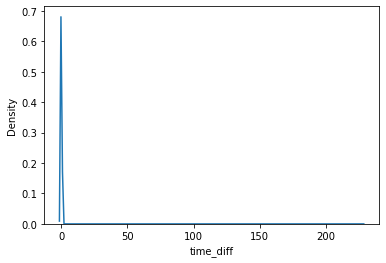

In [39]:
# Pub, Bar 등 술집 방문의 경우,
# 240분 이내(4시간 이내) 인증한 경우를 다음과 같이 분포도 확인하였다.
# 지나치게 짧은 시간은 술집 POI를 여러번 체크인(인증)하였기 때문으로 추측됨.
sns.kdeplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'] == 'Bar')
& (nyc_data_sorted.timedelta_min < 240)]['time_diff']/datetime.timedelta(minutes=1), bw=0.1)

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

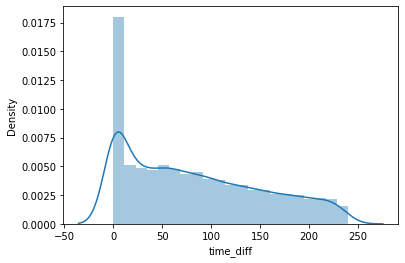

In [135]:
sns.distplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'] == 'Bar')
& (nyc_data_sorted.timedelta_min < 240)]['time_diff']/datetime.timedelta(minutes=1))

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

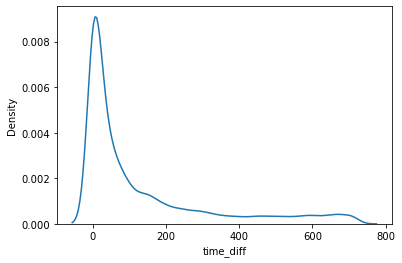

In [134]:
# Office 직장 방문의 경우,
# 720분(12시간) 이내 다른 POI를 인증한 경우를 다음과 같이 분포도 확인하였다.
sns.kdeplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'] == 'Office')
& (nyc_data_sorted.timedelta_min < 720)]['time_diff']/datetime.timedelta(minutes=1), bw=0.1)

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

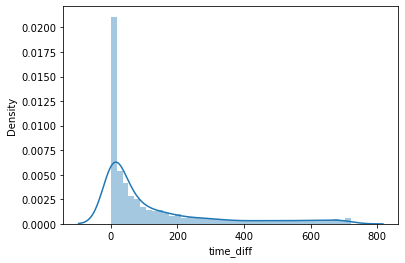

In [133]:
sns.distplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'] == 'Office')
& (nyc_data_sorted.timedelta_min < 720)]['time_diff']/datetime.timedelta(minutes=1))

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

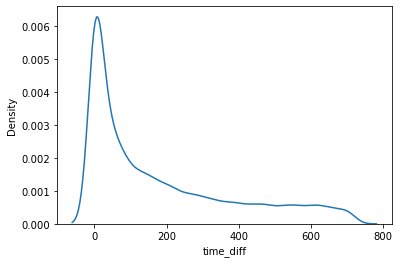

In [139]:
sns.kdeplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'].str.contains('Home'))
& (nyc_data_sorted.timedelta_min < 720)]['time_diff']/datetime.timedelta(minutes=1), bw=0.1)

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

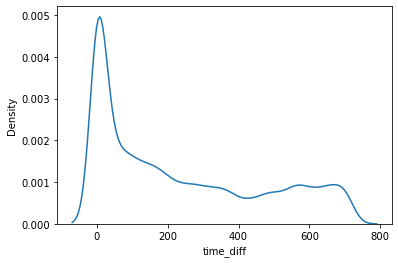

In [140]:
sns.kdeplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'].str.contains('Gym'))
& (nyc_data_sorted.timedelta_min < 720)]['time_diff']/datetime.timedelta(minutes=1), bw=0.1)

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

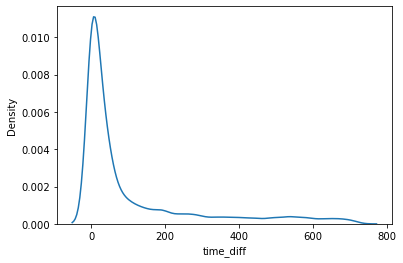

In [141]:
sns.kdeplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'].str.contains('Subway'))
& (nyc_data_sorted.timedelta_min < 720)]['time_diff']/datetime.timedelta(minutes=1), bw=0.1)

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

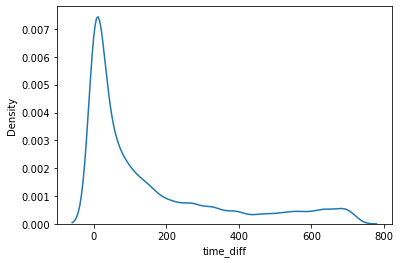

In [142]:
sns.kdeplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'].str.contains('Coffee'))
& (nyc_data_sorted.timedelta_min < 720)]['time_diff']/datetime.timedelta(minutes=1), bw=0.1)

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

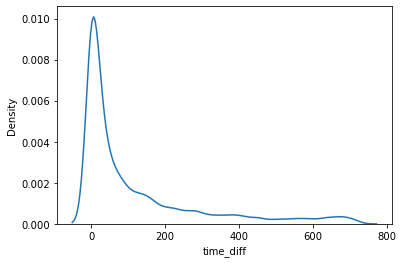

In [144]:
sns.kdeplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'].str.contains('Park'))
& (nyc_data_sorted.timedelta_min < 720)]['time_diff']/datetime.timedelta(minutes=1), bw=0.1)

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

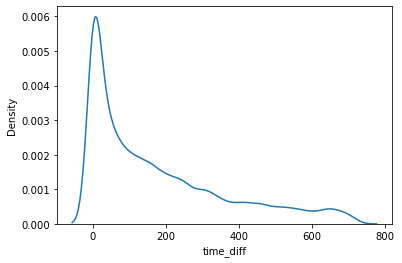

In [143]:
sns.kdeplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'].str.contains('Restaurant'))
& (nyc_data_sorted.timedelta_min < 720)]['time_diff']/datetime.timedelta(minutes=1), bw=0.1)

In [106]:
(nyc_data_sorted[nyc_data_sorted['venueCategory'].str.contains('Bar')
| nyc_data_sorted['venueCategory'].str.contains('Pub')
| nyc_data_sorted['venueCategory'].str.contains('pub')]['time_diff']/datetime.timedelta(minutes=1)).head(100)

6        192.416667
10       569.650000
12        97.283333
17        43.583333
23       602.300000
           ...     
1758     514.833333
2072     447.733333
2086      82.783333
2366    1716.400000
2416     188.166667
Name: time_diff, Length: 100, dtype: float64

## 중복을 제거한 버전으로 분석

In [36]:
# 우선 중복 제거
condition = nyc_data_sorted[nyc_data_sorted['duplicate'] == True].index
nyc_data_sorted.drop(condition, inplace= True)

In [37]:
nyc_data_sorted.reset_index(inplace= True, drop= True)

In [38]:
nyc_data_sorted

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,duplicate,timedelta_min
0,1,4abc1f51f964a520798620e3,4bf58dd8d48988d1ce941735,Seafood Restaurant,40.781558,-73.975792,-240,2012-04-04 23:31:31,2012-04-04 19:31:31,19,True,2,True,2 days 18:10:53,False,3970.883333
1,1,4d4ac10da0ef54814b6ffff6,4bf58dd8d48988d157941735,American Restaurant,40.784018,-73.974524,-240,2012-04-07 17:42:24,2012-04-07 13:42:24,13,False,5,False,1 days 00:38:05,False,1478.083333
2,1,4db44994cda1c57c82583709,4bf58dd8d48988d1f1931735,General Entertainment,40.739398,-73.993210,-240,2012-04-08 18:20:29,2012-04-08 14:20:29,14,False,6,False,0 days 01:41:41,False,101.683333
3,1,4a541923f964a52008b31fe3,4bf58dd8d48988d14e941735,American Restaurant,40.785677,-73.976498,-240,2012-04-08 20:02:10,2012-04-08 16:02:10,16,False,6,False,0 days 20:18:42,False,1218.700000
4,1,40f1d480f964a5205b0a1fe3,4bf58dd8d48988d143941735,Breakfast Spot,40.719929,-74.008532,-240,2012-04-09 16:20:52,2012-04-09 12:20:52,12,False,0,True,0 days 08:03:39,False,483.650000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192121,1083,49f4dca6f964a520626b1fe3,4bf58dd8d48988d1c1941735,Mexican Restaurant,40.735174,-73.979597,-300,2013-02-02 04:19:34,2013-02-01 23:19:34,23,True,4,True,0 days 00:00:00,False,29.033333
192122,1083,40b68100f964a52085001fe3,4bf58dd8d48988d116941735,Bar,40.737831,-73.981022,-300,2013-02-02 04:48:36,2013-02-01 23:48:36,23,True,4,True,0 days 00:00:00,False,8329.316667
192123,1083,4eda64ced5fb8f213a5d740e,4bf58dd8d48988d176941735,Gym / Fitness Center,40.746119,-73.993070,-300,2013-02-07 23:37:55,2013-02-07 18:37:55,18,True,3,True,0 days 00:00:00,False,817.183333
192124,1083,51140198e4b0874a568cde81,4bf58dd8d48988d162941735,Other Great Outdoors,40.757790,-73.981934,-300,2013-02-08 13:15:06,2013-02-08 08:15:06,8,False,4,True,0 days 00:00:00,False,4474.733333


In [39]:
nyc_data_sorted['time_diff'] = (nyc_data_sorted.utcTimestampOffset.shift(-1) - nyc_data_sorted.utcTimestampOffset)
nyc_data_sorted['timedelta_min'] = nyc_data_sorted['time_diff']/datetime.timedelta(minutes=1)

In [40]:
nyc_data_sorted

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,duplicate,timedelta_min
0,1,4abc1f51f964a520798620e3,4bf58dd8d48988d1ce941735,Seafood Restaurant,40.781558,-73.975792,-240,2012-04-04 23:31:31,2012-04-04 19:31:31,19,True,2,True,2 days 18:10:53,False,3970.883333
1,1,4d4ac10da0ef54814b6ffff6,4bf58dd8d48988d157941735,American Restaurant,40.784018,-73.974524,-240,2012-04-07 17:42:24,2012-04-07 13:42:24,13,False,5,False,1 days 00:38:05,False,1478.083333
2,1,4db44994cda1c57c82583709,4bf58dd8d48988d1f1931735,General Entertainment,40.739398,-73.993210,-240,2012-04-08 18:20:29,2012-04-08 14:20:29,14,False,6,False,0 days 01:41:41,False,101.683333
3,1,4a541923f964a52008b31fe3,4bf58dd8d48988d14e941735,American Restaurant,40.785677,-73.976498,-240,2012-04-08 20:02:10,2012-04-08 16:02:10,16,False,6,False,0 days 20:18:42,False,1218.700000
4,1,40f1d480f964a5205b0a1fe3,4bf58dd8d48988d143941735,Breakfast Spot,40.719929,-74.008532,-240,2012-04-09 16:20:52,2012-04-09 12:20:52,12,False,0,True,0 days 08:03:39,False,483.650000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192121,1083,49f4dca6f964a520626b1fe3,4bf58dd8d48988d1c1941735,Mexican Restaurant,40.735174,-73.979597,-300,2013-02-02 04:19:34,2013-02-01 23:19:34,23,True,4,True,0 days 00:29:02,False,29.033333
192122,1083,40b68100f964a52085001fe3,4bf58dd8d48988d116941735,Bar,40.737831,-73.981022,-300,2013-02-02 04:48:36,2013-02-01 23:48:36,23,True,4,True,5 days 18:49:19,False,8329.316667
192123,1083,4eda64ced5fb8f213a5d740e,4bf58dd8d48988d176941735,Gym / Fitness Center,40.746119,-73.993070,-300,2013-02-07 23:37:55,2013-02-07 18:37:55,18,True,3,True,0 days 13:37:11,False,817.183333
192124,1083,51140198e4b0874a568cde81,4bf58dd8d48988d162941735,Other Great Outdoors,40.757790,-73.981934,-300,2013-02-08 13:15:06,2013-02-08 08:15:06,8,False,4,True,3 days 02:34:44,False,4474.733333


In [53]:
# POI 인증별 시간차 다시 update
nyc_data_sorted['time_diff'] = (nyc_data_sorted.utcTimestampOffset.shift(-1) - nyc_data_sorted.utcTimestampOffset)
nyc_data_sorted['timedelta_min'] = nyc_data_sorted['time_diff']/datetime.timedelta(minutes=1)
nyc_data_sorted.reset_index(inplace= True, drop= True)


In [57]:
for i in range(1, len(nyc_data_sorted) -1):
    if i == len(nyc_data_sorted) - 1:
        nyc_data_sorted.loc[i, 'time_diff'] = pd.to_timedelta(0, unit='h')
    if nyc_data_sorted.loc[i, "userId"] == nyc_data_sorted.loc[i-1, "userId"]:
        if ((nyc_data_sorted.loc[i, 'venueCategory'] == nyc_data_sorted.loc[i-1, 'venueCategory']) & (nyc_data_sorted.loc[i, 'timedelta_min'] < 60)) | (nyc_data_sorted.loc[i-1, 'timedelta_min'] < 3):
            # 같은 아이디 내에서 카테고리가 연달아 중복되는데, POI 인증 시간차가 60min 미만인 경우 or 다음 POI까지 인증이 3min 미만인 경우(POI는 다르게 중복 인증하는 실수를 한 경우)는 중복이라고 체크.
            nyc_data_sorted.loc[i, 'duplicate'] = True
    if (i > 0) & (nyc_data_sorted.loc[i, "userId"] != nyc_data_sorted.loc[i-1, "userId"]):
#        nyc_data_sorted.loc[i, 'time_diff'] = pd.to_timedelta(0, unit='h')
        nyc_data_sorted.loc[i-1,'time_diff'] = pd.to_timedelta(0, unit='h')

105
253
370
543
635
869
1142
1269
1427
1599
1725
2069
2176
2509
2731
2849
3009
3108
3404
3616
3757
3790
3996
4099
4391
4550
4683
4812
4984
5146
5250
5355
5499
5971
6072
6221
6405
6508
6654
6794
6912
7012
7208
7306
7399
7554
7658
7767
7986
8208
8372
8483
8625
8750
8854
9154
9293
9388
9520
9652
9770
9879
9990
10098
10478
10590
10706
10824
11132
11597
11750
11873
12073
12250
12376
12498
12643
12751
12883
13154
13557
13906
14078
14737
14875
14976
15094
15300
15445
15886
16221
16313
16582
16747
17191
17321
17389
17505
17828
18009
18110
18223
18257
18358
18509
18676
18835
18966
19078
19232
19368
19495
19610
19758
19911
20021
20134
20268
20597
21024
21323
21430
21541
21678
21794
21929
22036
22119
22324
22473
22584
22811
22916
23029
23144
23291
23432
23899
24020
24122
24226
24310
24462
24691
24866
24977
25079
25195
25355
25597
25703
25851
26123
26348
26520
26644
26744
26854
27004
27130
27231
27357
27480
27770
27898
28043
28148
28228
28409
28553
28799
29045
29248
29372
29517
29686
29788
30537
3

In [43]:
nyc_data_sorted[nyc_data_sorted['userId'] == 470].sort_values('utcTimestampOffset').head(10)

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,duplicate,timedelta_min
84420,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,40.719810,-74.002581,-240,2012-04-03 18:00:09,2012-04-03 14:00:09,14,False,1,True,0 days 05:36:25,False,336.416667
84421,470,4e08ad8cd4c03ae0b9d11f93,4bf58dd8d48988d1d2941735,Japanese Restaurant,40.683178,-73.965746,-240,2012-04-03 23:36:34,2012-04-03 19:36:34,19,True,1,True,0 days 00:42:11,False,42.183333
84422,470,4de808e8091a3279663a4303,4bf58dd8d48988d1e4931735,Bowling Alley,40.721988,-73.957536,-240,2012-04-04 00:18:45,2012-04-03 20:18:45,20,True,1,True,0 days 01:58:00,False,118.000000
84423,470,4ecb3c46f5b90c1c3318e4db,4bf58dd8d48988d1df931735,BBQ Joint,40.742965,-73.974162,-240,2012-04-04 02:16:45,2012-04-03 22:16:45,22,True,1,True,0 days 03:01:15,False,181.250000
84424,470,4baa441ff964a5201f593ae3,4bf58dd8d48988d1cb941735,Food Truck,40.757953,-73.829155,-240,2012-04-04 05:18:00,2012-04-04 01:18:00,1,True,2,True,0 days 00:29:12,False,29.200000
84425,470,4f4973f2e4b05ebee0868799,4bf58dd8d48988d1df931735,BBQ Joint,40.754239,-73.999413,-240,2012-04-04 05:47:12,2012-04-04 01:47:12,1,True,2,True,0 days 12:12:57,False,732.950000
84426,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,40.719810,-74.002581,-240,2012-04-04 18:00:09,2012-04-04 14:00:09,14,False,2,True,0 days 14:09:58,False,849.966667
84427,470,4e4e4bb9bd4101d0d7a714cf,4bf58dd8d48988d1d3941735,Vegetarian / Vegan Restaurant,40.777224,-73.949465,-240,2012-04-05 08:10:07,2012-04-05 04:10:07,4,True,3,True,2 days 19:17:33,False,4037.550000
84428,470,4ad9f3b3f964a520431c21e3,4bf58dd8d48988d12f941735,Library,40.774338,-73.984785,-240,2012-04-08 03:27:40,2012-04-07 23:27:40,23,True,5,False,0 days 05:35:04,False,335.066667
84429,470,42dc4280f964a5203a261fe3,4bf58dd8d48988d1d3941735,Vegetarian / Vegan Restaurant,40.788608,-73.974222,-240,2012-04-08 09:02:44,2012-04-08 05:02:44,5,True,6,False,0 days 08:57:23,False,537.383333


In [58]:
nyc_data_sorted[nyc_data_sorted['timedelta_min'] < 0]

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,duplicate,timedelta_min
104,1,4ace6c89f964a52078d020e3,4bf58dd8d48988d1ed931735,Airport,40.773839,-73.871220,-300,2012-12-15 00:13:02,2012-12-14 19:13:02,19,True,4,True,0 days,False,-366329.266667
252,2,42ec1480f964a5209e261fe3,4bf58dd8d48988d1e2941735,Beach,40.567089,-73.865461,-300,2013-02-13 19:16:40,2013-02-13 14:16:40,14,False,2,True,0 days,False,-454707.000000
369,3,50f0d0bfe4b07d6a11535185,4bf58dd8d48988d1c4941735,Restaurant,40.746390,-74.000923,-300,2013-02-06 00:49:03,2013-02-05 19:49:03,19,True,1,True,0 days,False,-443639.150000
542,4,4b376908f964a520ef4025e3,4bf58dd8d48988d132941735,Church,40.816816,-73.941393,-300,2013-02-14 00:37:40,2013-02-13 19:37:40,19,True,2,True,0 days,False,-358951.016667
634,5,4e0123ec62843b639cfab90d,4bf58dd8d48988d118951735,Food & Drink Shop,40.728917,-74.041350,-300,2012-11-20 00:44:50,2012-11-19 19:44:50,19,True,0,True,0 days,False,-10947.533333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191230,1077,3fd66200f964a52036e31ee3,4bf58dd8d48988d16c941735,Burger Joint,40.728533,-73.987809,-300,2013-02-14 02:56:37,2013-02-13 21:56:37,21,True,2,True,0 days,False,-455355.000000
191384,1078,50780a9be4b00277f24ad107,4bf58dd8d48988d103941735,Home (private),40.782438,-74.141613,-300,2013-02-14 02:45:52,2013-02-13 21:45:52,21,True,2,True,0 days,False,-455068.883333
191514,1079,43a52546f964a520532c1fe3,4bf58dd8d48988d1ed931735,Airport,40.645089,-73.784523,-300,2012-12-17 18:26:18,2012-12-17 13:26:18,13,False,0,True,0 days,False,-367365.433333
191740,1081,4e6f6d07d22de801639a8ba2,4bf58dd8d48988d1a1941735,College Academic Building,40.721924,-73.796819,-300,2013-02-14 01:16:34,2013-02-13 20:16:34,20,True,2,True,0 days,False,-455070.733333


In [55]:
nyc_data_sorted[102:107]

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,duplicate,timedelta_min
102,1,3fd66200f964a52048e31ee3,4bf58dd8d48988d1ce941735,Seafood Restaurant,40.734895,-74.003155,-300,2012-12-14 17:55:32,2012-12-14 12:55:32,12,False,4,True,0 days 00:53:31,False,53.516667
103,1,4a8a0db0f964a520c50920e3,4bf58dd8d48988d10d951735,Record Shop,40.733022,-74.004033,-300,2012-12-14 18:49:03,2012-12-14 13:49:03,13,False,4,True,0 days 05:23:59,False,323.983333
104,1,4ace6c89f964a52078d020e3,4bf58dd8d48988d1ed931735,Airport,40.773839,-73.871220,-300,2012-12-15 00:13:02,2012-12-14 19:13:02,19,True,4,True,-255 days +14:30:44,False,-366329.266667
105,2,4ef372169adf60f8399b4bd7,4bf58dd8d48988d16a941735,Bakery,40.746577,-73.981732,-240,2012-04-04 13:43:46,2012-04-04 09:43:46,9,False,2,True,0 days 01:52:23,False,112.383333
106,2,49cbb6f9f964a5200f591fe3,4bf58dd8d48988d1f6941735,Department Store,40.758315,-73.977284,-240,2012-04-04 15:36:09,2012-04-04 11:36:09,11,False,2,True,3 days 23:35:42,False,5735.700000


c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

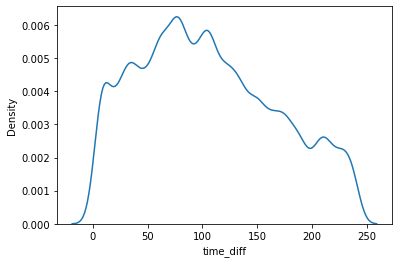

In [88]:
# Pub, Bar 등 술집 방문의 경우,
# 240분 이내(4시간 이내) 인증한 경우를 다음과 같이 분포도 확인하였다.
# 지나치게 짧은 시간은 술집 POI를 여러번 체크인(인증)하였기 때문으로 추측됨.
sns.kdeplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'] == 'Bar')
& (nyc_data_sorted.timedelta_min < 240) & (nyc_data_sorted.timedelta_min > 0)]['time_diff']/datetime.timedelta(minutes=1), bw=0.1)

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

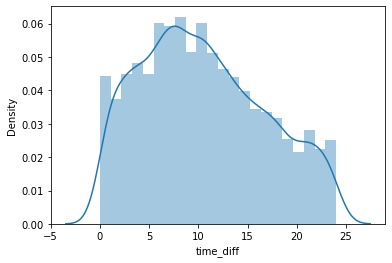

In [87]:
sns.distplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'] == 'Bar')
& (nyc_data_sorted.timedelta_min < 240) & (nyc_data_sorted.timedelta_min > 0)]['time_diff']/datetime.timedelta(minutes=10))

In [94]:
# 술집에서는 2시간 정도 체류.

nyc_data_sorted[(nyc_data_sorted['venueCategory'] == 'Bar')
& (nyc_data_sorted.timedelta_min < 360) & (nyc_data_sorted.timedelta_min > 0)]['time_diff'].mean()
# nyc_data_sorted[(nyc_data_sorted['venueCategory'] == 'Bar')
# & (nyc_data_sorted.timedelta_min < 240) & (nyc_data_sorted.timedelta_min > 0)]['timedelta_min'].mean()

Timedelta('0 days 02:07:04.894354387')

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

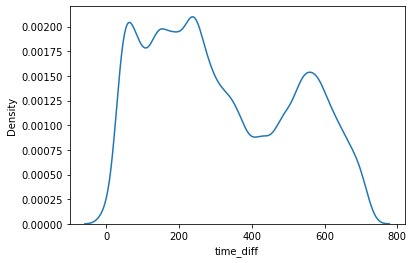

In [80]:
# Office 직장 방문의 경우,
# 720분(12시간) 이내 다른 POI를 인증한 경우를 다음과 같이 분포도를 확인하였다.
sns.kdeplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'] == 'Office')
& (nyc_data_sorted.timedelta_min < 720) & (nyc_data_sorted.timedelta_min > 30)]['time_diff']/datetime.timedelta(minutes=1), bw=0.1)

In [96]:
# 오피스에서는 5시간 정도 체류.
nyc_data_sorted[(nyc_data_sorted['venueCategory'] == 'Office')
& (nyc_data_sorted.timedelta_min < 720) & (nyc_data_sorted.timedelta_min > 0)]['time_diff'].mean()

Timedelta('0 days 04:49:15.587617861')

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

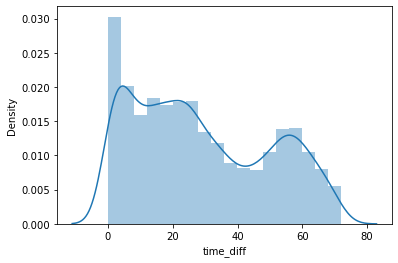

In [81]:
sns.distplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'] == 'Office')
& (nyc_data_sorted.timedelta_min < 720) & (nyc_data_sorted.timedelta_min > 0)]['time_diff']/datetime.timedelta(minutes=10))

In [99]:
# 식당에서는 평균 2시간 체류(6시간 미만으로만 조회했으나, 12시간 미만으로 조회할 경우에는 평균이 3시간으로 증가)
nyc_data_sorted[(nyc_data_sorted['venueCategory'] == 'Restaurant')
& (nyc_data_sorted.timedelta_min < 360) & (nyc_data_sorted.timedelta_min > 0)]['time_diff'].mean()

Timedelta('0 days 02:03:10.278481012')

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

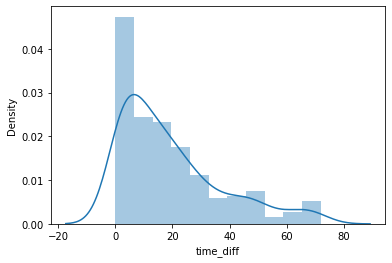

In [82]:
sns.distplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'] == 'Restaurant')
& (nyc_data_sorted.timedelta_min < 720) & (nyc_data_sorted.timedelta_min > 0)]['time_diff']/datetime.timedelta(minutes=10))

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

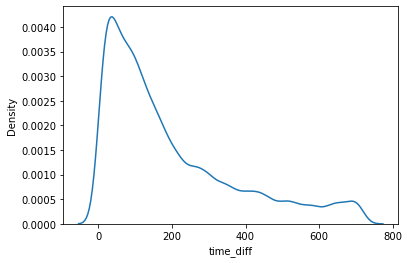

In [65]:
sns.kdeplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'].str.contains('Restaurant'))
& (nyc_data_sorted.timedelta_min < 720) & (nyc_data_sorted.timedelta_min > 5)]['time_diff']/datetime.timedelta(minutes=1), bw=0.1)

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

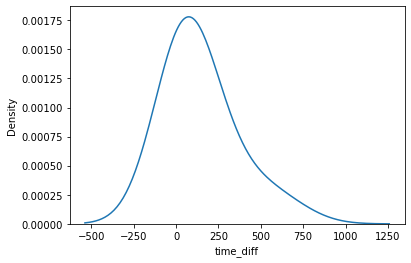

In [68]:
sns.kdeplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'].str.contains('Subway'))
& (nyc_data_sorted.timedelta_min < 720) & (nyc_data_sorted.timedelta_min > 5)]['time_diff']/datetime.timedelta(minutes=1), bw=1)

In [1]:
for i in range(1, len(nyc_data_sorted) -1):
    if i == len(nyc_data_sorted) - 1:
        nyc_data_sorted.loc[i, 'time_diff'] = pd.to_timedelta(0, unit='h')
    if nyc_data_sorted.loc[i, "userId"] == nyc_data_sorted.loc[i-1, "userId"]:
        if ((nyc_data_sorted.loc[i, 'venueCategory'] == nyc_data_sorted.loc[i-1, 'venueCategory']) & (nyc_data_sorted.loc[i, 'timedelta_min'] < 60)) | (nyc_data_sorted.loc[i-1, 'timedelta_min'] < 3):
            # 같은 아이디 내에서 카테고리가 연달아 중복되는데, POI 인증 시간차가 60min 미만인 경우 or 다음 POI까지 인증이 3min 미만인 경우(POI는 다르게 중복 인증하는 실수를 한 경우)는 중복이라고 체크.
            nyc_data_sorted.loc[i, 'duplicate'] = True
    if (i > 0) & (nyc_data_sorted.loc[i, "userId"] != nyc_data_sorted.loc[i-1, "userId"]):
#        nyc_data_sorted.loc[i, 'time_diff'] = pd.to_timedelta(0, unit='h')
        nyc_data_sorted.loc[i-1,'time_diff'] = pd.to_timedelta(0, unit='h')
        nyc_data_sorted.loc[i-1,'timedelta_min'] = 0

NameError: name 'nyc_data_sorted' is not defined

In [105]:
nyc_data_sorted.to_csv('refined_nyc_data.csv')

In [49]:
import pandas as pd
poi_list = pd.read_csv('C:/Users/piai/Desktop/code_file/category_list_for_categorize.txt', header = None)
poi_list.columns = ['venueCategory','Category']
poi_list.head()

,venueCategory,Category
0,Post Office,Other
1,Jazz Club,Liquid
2,Gym,Exercise
3,Indian Restaurant,Meal
4,Sandwich Place,Meal


In [50]:
poi_list

,venueCategory,Category
0,Post Office,Other
1,Jazz Club,Liquid
2,Gym,Exercise
3,Indian Restaurant,Meal
4,Sandwich Place,Meal
...,...,...
512,Comfort Food Restaurants,Meal
513,Bistros,Meal
514,Country Dance Clubs,Leisure
515,Go Kart Tracks,Leisure


In [51]:
poi_list[poi_list['Category'].isnull()]

,venueCategory,Category


In [52]:
poi_list['Category'].unique()

array(['Other', 'Liquid', 'Exercise', 'Meal', 'Entertain', 'Nightlife',
       'Shopping', 'Snack', 'Cafe', 'Leisure', 'Medical', 'Work', 'Hobby',
       'Residence', 'Hairshop', 'Station', 'School', 'Entertainment',
       'Sightseeing', 'Transportation', 'Retail', 'Event'], dtype=object)

In [56]:
poi_list[poi_list['Category'] == 'Residence']

,venueCategory,Category
87,Hotel,Residence
105,Hostel,Residence
139,Residential Building (Apartment / Condo),Residence
183,Home (private),Residence
201,College Residence Hall,Residence
228,Sorority House,Residence
296,Fraternity House,Residence
337,Motel,Residence
343,Bed & Breakfast,Residence
345,Boarding House,Residence
